In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
train_reg = pd.read_csv('train_reg.csv')
test_reg = pd.read_csv('test_reg.csv')

In [3]:
display(train_reg.tail(5))
display(test_reg.head(5))


,x,y
95,7.213907,19.271893
96,-0.173887,0.688316
97,3.423655,9.814922
98,9.486892,29.445184
99,5.473476,12.726861


,x
0,5.913738
1,2.657985
2,-0.666239
3,9.891288
4,7.224223


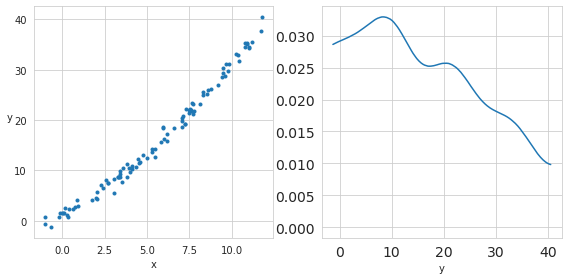

In [4]:
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(train_reg['x'], train_reg['y'], 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)

az.plot_kde(train_reg['y'], ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()


In [5]:
x = train_reg['x']
y = train_reg['y']

# x = (x - x.mean())/x.std()
# y = (y - y.mean())/y.std()

### Задание 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.688,0.311,-1.280,-0.106,0.005,0.004,3831.0,3894.0,1.0
β,3.081,0.048,2.991,3.171,0.001,0.001,3965.0,4084.0,1.0
ε,1.693,0.121,1.468,1.921,0.002,0.001,4769.0,4646.0,1.0
μ[0],0.593,0.294,0.036,1.144,0.005,0.003,3877.0,3975.0,1.0
μ[1],5.716,0.233,5.296,6.176,0.004,0.003,4260.0,4978.0,1.0
...,...,...,...,...,...,...,...,...,...
μ[95],21.541,0.188,21.196,21.901,0.002,0.001,9667.0,6552.0,1.0
μ[96],-1.224,0.318,-1.808,-0.609,0.005,0.004,3816.0,3927.0,1.0
μ[97],9.862,0.193,9.503,10.223,0.003,0.002,5145.0,5739.0,1.0
μ[98],28.545,0.258,28.078,29.041,0.003,0.002,6861.0,6634.0,1.0


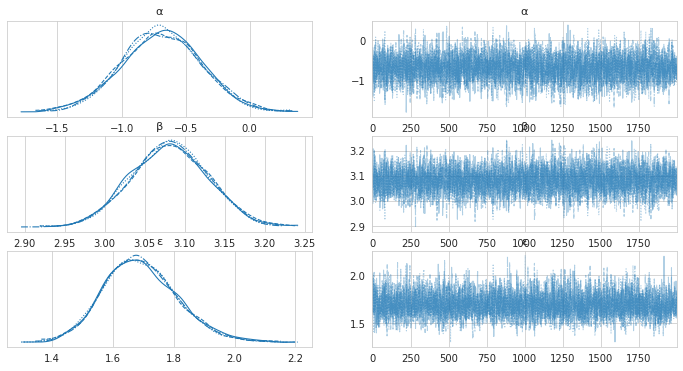

In [6]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1) 
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)
    

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g)

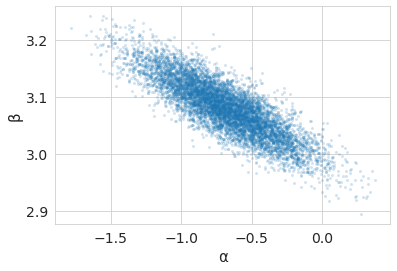

In [7]:
az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.2});

всего трасс :  8000


/tmp/ipykernel_6551/2085329640.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.1)


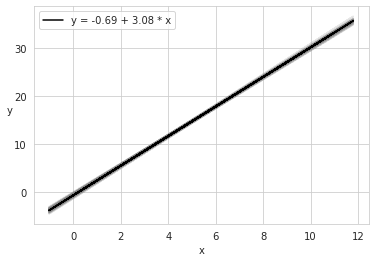

In [8]:
posterior_g = az.extract(trace_g)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(x, posterior_g['α'][draws].values +
                 posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.1)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

### Задание 2

In [9]:
ppc = pm.sample_posterior_predictive(trace_g, model=model_g)

Sampling: [y_pred]


In [10]:
alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
beta = trace_g.posterior["β"].mean(("chain", "draw")).values


y_pred = alpha+beta*(test_reg['x'])

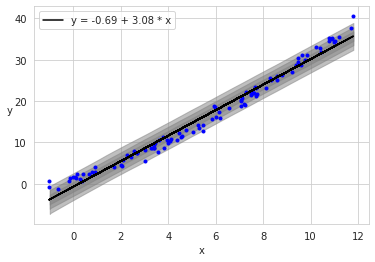

In [11]:

ax0 = az.plot_hdi(x, ppc.posterior_predictive['y_pred'], color='gray')#, smooth=False)
ax1 = az.plot_hdi(x, ppc.posterior_predictive['y_pred'], ax=ax0, hdi_prob=0.8, color='gray') # smooth=False
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], ax=ax1, hdi_prob=0.5, color='gray')  # smooth=False

plt.plot(x, y, '.', color = 'blue')
plt.plot(x, alpha + beta * x, c='k',
            label = f'y = {alpha:.2f} + {beta:.2f} * x')


plt.xlabel('x'); 
plt.ylabel('y', rotation=0);
plt.legend();

In [12]:
y_pred

0     17.534545
1      7.502417
2     -2.740692
3     29.790784
4     21.572613
        ...    
95    27.640956
96    31.930729
97     4.996406
98     0.969705
99    19.052690
Name: x, Length: 100, dtype: float64